# BJT 三极管基础知识复习

In [1]:
%matplotlib inline
%load_ext tikzmagic

from math import exp, log, log10
import numpy as np
from matplotlib import pyplot as plt
import ngspyce as ng

# kΩ μA

def para(r1, r2):
  return (r1*r2) / (r1 + r2)

In [3]:
def print_op(show_ib=True, show_ie=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if '[i' in k or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ie]' in k and not show_ie:
            continue
        if '[ib]' in k and not show_ib:
            continue
        current = op[k][0]
        k = k.replace('q.x.', '')
        k = k.replace('r.x.', '')
        if abs(current) > 1e-3:
            print('%10s = %8.3f mA' % (k, 1e3*current))
        else:
            print('%10s = %8.3f uA' % (k, 1e6*current))
    elif '[g' in k:
        gm = op[k][0]
        if gm > 10e-3:
            print('%10s = %8.3f mS' % (k, 1e3 * gm))
        else:
            print('%10s = %8.3f uS' % (k, 1e6 * gm))
    else:  # Voltage
        voltage = op[k][0]
        k = k.replace('x.', '')
        if abs(voltage) > 10e-3:
            print('%10s = %8.4f V' % (k, voltage))
        else:
            print('%10s = %8.1f uV' % (k, 1e6*voltage))


## 基本模型
$\newcommand{\li}[1]{{i_\mathrm{#1}}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}}$
$\newcommand{\lv}[1]{{v_\mathrm{#1}}}$
$\newcommand{\uv}[1]{{V_\mathrm{#1}}}$
$\newcommand{\sm}[2]{{{#1}_\mathrm{#2}}}$
物理常数，注意 SPICE 用的 $k$ / $q$ 常数是旧值。

In [6]:
boltz = 1.38064852e-23
echarge = 1.60217662e-19
kelvin = 273.15
ng.vectors()

{'planck': array([6.62607004e-34]),
 'boltz': array([1.38064852e-23]),
 'echarge': array([1.60217662e-19]),
 'kelvin': array([-273.15]),
 'i': array([0.+1.j]),
 'c': array([2.99792458e+08]),
 'e': array([2.71828183]),
 'pi': array([3.14159265]),
 'FALSE': array([0.]),
 'no': array([0.]),
 'TRUE': array([1.]),
 'yes': array([1.])}

### Ebers-Moll 大型号模型

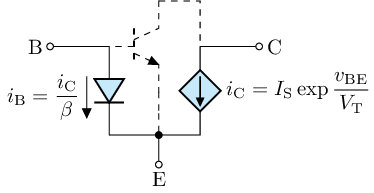

In [4]:
%%tikz -ct
\ctikzset{european voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw [dashed] (0, 0) node [npn] (Q) {}; 
\draw (Q.B) to [D, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (Q.B) to [short, -o] ++(-1, 0) node [left] {B};
\draw [dashed] (Q.E) to [short] (Q.E |- E); 
\draw (Q.E |- E) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (Q) ++(0.7, 0) coordinate (C) 
  to [american controlled current source, l={$\li{C}=\ui{S}\exp\displaystyle\frac{\lv{BE}}{\uv{T}}$}, bipoles/length=1cm] (C|-E)
  -- (E);
\draw (C) to [short, -o] ++(1, 0) node [right] {C};
\draw [dashed] (Q.C) -| (C);
\draw (Q.B)++(-0.1,0) to [open, f_={$\li{B}=\displaystyle\frac{\li{C}}{\beta}$}] ++(0, -1);

In [7]:
Vt = boltz * (27+kelvin) / echarge
print(Vt)

0.02586491702007235


In [49]:
Is = 1e-15
Vbe = 0.7
Ic = Is * exp(Vbe / Vt)
gm = Ic / Vt
print('Ic', Ic)
print('gm', gm)

Ic 0.0005670346694806257
gm 0.02192292629590039


In [44]:
ng.circ('''
  Q  c b 0 NPN
  Vc c 0 1V
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm] @q[gpi]
''')
ng.operating_point()
# print_op()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


{'@q[gpi]': array([0.00021923]),
 '@q[gm]': array([0.02192293]),
 'vc#branch': array([-0.00056703]),
 'vb#branch': array([-5.67034717e-06]),
 'b': array([0.7]),
 'c': array([1.])}

In [23]:
Ic2 = -ng.vector('vc#branch')[0]
print('%.5f uA (SPICE)' % (Ic2 * 1e6))
print('%.5f uA (EM)' % (Ic * 1e6))

567.03468 uA (SPICE)
567.03467 uA (EM)


In [20]:
Ib = -ng.vector('vb#branch')[0]
print('%.7f uA (SPICE)' % (Ib * 1e6))
print('%.7f uA (EM)' % (Ic / 100 * 1e6))

5.6703472 uA (SPICE)
5.6703467 uA (EM)


In [36]:
gm2 = ng.vector('@q[gm]')[0]
print('%.5f mS (SPICE)' % (gm2 * 1e3))
print('%.5f mS (EM)' % (gm * 1e3))

21.92293 mS (SPICE)
21.92293 mS (EM)


#### Curve tracer

### Early effect

Affects $\li{C}$, not $\li{B}$

$\li{C}=\ui{S}\exp\dfrac{\lv{BE}}{\uv{T}}\big(1+\dfrac{\lv{CE}}{\uv{A}}\big)$

$\li{B}=\dfrac{\ui{S}}{\beta}\exp\dfrac{\lv{BE}}{\uv{T}}$

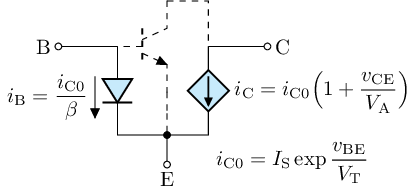

In [66]:
%%tikz -ct -p amsmath
\ctikzset{european voltages, american currents, european resistors}
\ctikzset{transistors/arrow pos=end, transistors/fill=cyan!20}
\ctikzset{diodes/fill=cyan!20, csources/fill=cyan!20}

\newcommand{\li}[1]{\ensuremath{i_\mathrm{#1}}}
\newcommand{\ui}[1]{\ensuremath{I_\mathrm{#1}}}
\newcommand{\lv}[1]{\ensuremath{v_\mathrm{#1}}}
\newcommand{\uv}[1]{\ensuremath{V_\mathrm{#1}}}

\draw [dashed] (0, 0) node [npn] (Q) {}; 
\draw (Q.B) to [D, bipoles/length=1cm] ++(0, -1.5) coordinate (E);
\draw (Q.B) to [short, -o] ++(-1, 0) node [left] {B};
\draw [dashed] (Q.E) to [short] (Q.E |- E); 
\draw (Q.E |- E) to [short, *-o] ++(0, -0.5) node [below] {E};
\draw (Q) ++(0.7, 0) coordinate (C) 
  to [american controlled current source, l={$\li{C}=\li{C0}\Big(1+\dfrac{\lv{CE}}{\uv{A}}\Big)$}, bipoles/length=1cm] (C|-E)
  node [below right] {$\li{C0}=\ui{S}\exp\displaystyle\frac{\lv{BE}}{\uv{T}}$}
  -- (E);
\draw (C) to [short, -o] ++(1, 0) node [right] {C};
\draw [dashed] (Q.C) -| (C);
\draw (Q.B)++(-0.1,0) to [open, f_={$\li{B}=\displaystyle\frac{\li{C0}}{\beta}$}] ++(0, -1);

In [39]:
ng.circ('''
  Q  c b 0 NPN
  Vc c 0 10V
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100 VAF=150)
  .save all @q[gm]
''')
ng.operating_point()
# print_op()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


{'@q[gm]': array([0.02327837]),
 'vc#branch': array([-0.00060219]),
 'vb#branch': array([-5.67033817e-06]),
 'b': array([0.7]),
 'c': array([10.])}

But, SPICE uses $\lv{CB}$, not $\lv{CE}$.

In [26]:
Vcb = 10 - Vbe
Vaf = 150
Ic3 = Ic * (1 + Vcb / Vaf)

Ic2 = -ng.vector('vc#branch')[0]
print('%.5f uA (SPICE)' % (Ic2 * 1e6))
print('%.5f uA (EM)' % (Ic3 * 1e6))

602.19085 uA (SPICE)
602.19082 uA (EM)


In [27]:
Ib = -ng.vector('vb#branch')[0]
print('%.7f uA (SPICE)' % (Ib * 1e6))
print('%.7f uA (EM)' % (Ic / 100 * 1e6))

5.6703382 uA (SPICE)
5.6703467 uA (EM)


In [42]:
gm3 = ng.vector('@q[gm]')[0]
print('gm %.3f mS (SPICE)' % (gm3 * 1e3))
print('gm %.3f mS (EM)' % (1e3 * Ic3 / Vt))

gm 23.278 mS (SPICE)
gm 23.282 mS (EM)


#### Curve tracer

### 低频小信号 hybrid-pi 模型

Input impedance

$r_\pi = \dfrac{\uv{T}}{\ui{B}}$

$r_\pi = \dfrac{\beta}{\sm{g}{m}}$ when ignoring Early effects.

In [53]:
Is = 1e-15
Vbe = 0.7
beta = 100
Ib = Is / beta * exp(Vbe / Vt)

print('rpi', Vt / Ib)

rpi 4561.434849083085


In [47]:
ng.circ('''
  Q  c b 0 NPN
  Ic 0 c 600u
  Vb b 0 0.7V
  .model NPN NPN(IS=1fA BF=100 VAF=150)
  .save all @q[gm]
''')
ng.operating_point()
# print_op()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


{'@q[gm]': array([0.02319366]),
 'vb#branch': array([-5.67033875e-06]),
 'b': array([0.7]),
 'c': array([9.42044675])}

In [48]:
ng.cmd('tf v(c) vb')
ng.vectors()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


{'@q[gm]': array([0.02319366]),
 'output_impedance_at_V(c)': array([264533.94595817]),
 'vb#Input_impedance': array([4561.30708746]),
 'Transfer_function': array([-6135.51158203])}

Output impedance

$\sm{r}{o} = \dfrac{\uv{A}}{\ui{C}}$ for $\ui{C}|_{\uv{BC}=0}$

In [58]:
Ic = Is * exp(Vbe / Vt)
ro = Vaf / Ic
print(ro)

264534.08948943496


Intrinsic gain $A_0 = \dfrac{\uv{A}}{\uv{T}}$

In [59]:
print(Vaf/Vt)

5799.36134663


## Common-Emitter amplifier

Load resistor $\sm{R}{C}$

In [72]:
ng.circ('''
  Q  c b 0 NPN
  Vc vcc 0  10V
  Vb b 0 0.7V
  Rc vcc c  10k
  .model NPN NPN(IS=1fA BF=100)
  .save all @q[gm]
''')
#ng.operating_point()
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


    @q[gm] =   21.923 mS
         b =   0.7000 V
         c =   4.3297 V
 vb#branch =   -5.670 uA
 vc#branch = -567.035 uA
       vcc =  10.0000 V


{'@q[gm]': array([0.02192293]),
 'output_impedance_at_V(c)': array([9999.9998]),
 'vb#Input_impedance': array([4561.43018212]),
 'Transfer_function': array([-219.22926164])}

In [73]:
Is = 1e-15
Vbe = 0.7
Ic = Is * exp(Vbe / Vt)
gm = Ic / Vt
print('Ic', Ic)
print('gm', gm)
Rc = 10e3
print('Av', gm * Rc)

Ic 0.0005670346694806257
gm 0.02192292629590039
Av 219.2292629590039


#### Early effect

In [76]:
ng.circ('''
  Q  c b 0 NPN
  Vc vcc 0  10V
  Vb b 0 0.7V
  Rc vcc c  10k
  .model NPN NPN(IS=1fA BF=100 VAF=150)
  .save all @q[gm]
''')
print_op()
ng.cmd('tf v(c) vb')
ng.vectors()

ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver
ERROR:ngspyce.sharedspice:Using SPARSE 1.3 as Direct Linear Solver


    @q[gm] =   22.430 mS
         b =   0.7000 V
         c =   4.1974 V
 vb#branch =   -5.670 uA
 vc#branch = -580.256 uA
       vcc =  10.0000 V


{'@q[gm]': array([0.02243031]),
 'output_impedance_at_V(c)': array([9635.74632036]),
 'vb#Input_impedance': array([4561.43024655]),
 'Transfer_function': array([-216.1327523])}

## Common-Emitter with degeneration

## Common-Emitter with active load

## Emitter follower

### Active load

## Differential pair

### Active load